## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/colab-datasets/hotdog_nothotdog'

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data

In [ ]:
print(len(trainset))

2047


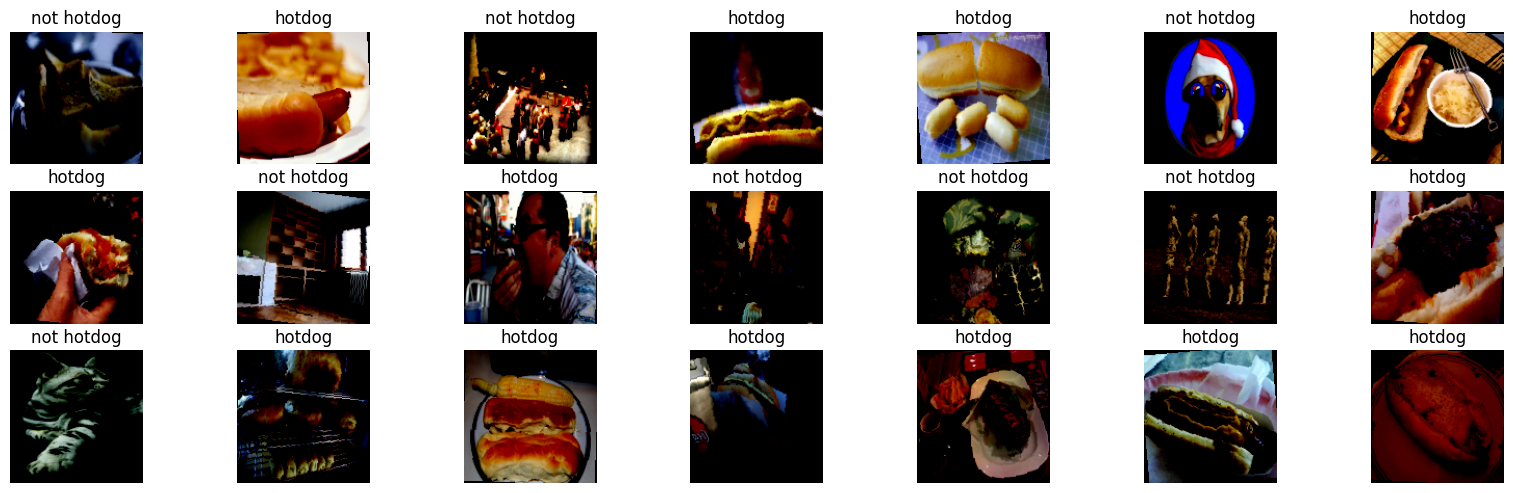

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    # Define the loss function outside the loop
    criterion = nn.CrossEntropyLoss()

    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target) # Use the created instance
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item()) # Use the created instance
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 10.942	 test: 1.346	 Accuracy train: 61.4%	 test: 62.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.782	 test: 0.558	 Accuracy train: 69.7%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.536	 test: 0.532	 Accuracy train: 74.0%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.520	 Accuracy train: 74.6%	 test: 73.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.496	 test: 0.510	 Accuracy train: 76.7%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.486	 test: 0.509	 Accuracy train: 76.6%	 test: 74.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.507	 Accuracy train: 76.8%	 test: 75.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.491	 test: 0.553	 Accuracy train: 77.3%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.488	 test: 0.497	 Accuracy train: 77.3%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.447	 test: 0.528	 Accuracy train: 79.8%	 test: 74.7%


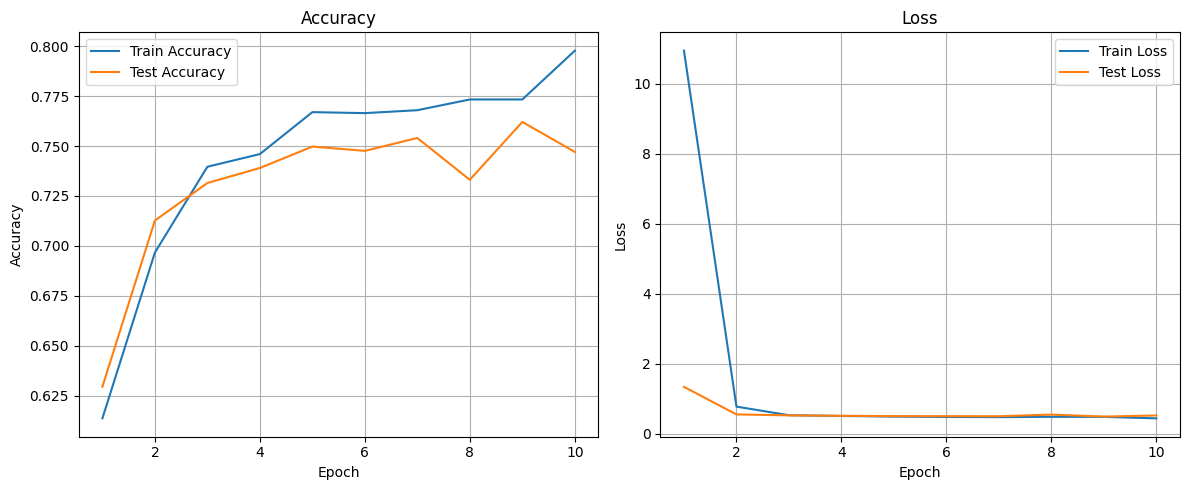

In [ ]:
num_epochs = 10
out_dict = train(model, optimizer, num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy ---
ax[0].plot(range(1, num_epochs + 1), out_dict['train_acc'], label="Train Accuracy")
ax[0].plot(range(1, num_epochs + 1), out_dict['test_acc'], label="Test Accuracy")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()
ax[0].grid(True)

# --- Loss ---
ax[1].plot(range(1, num_epochs + 1), out_dict['train_loss'], label="Train Loss")
ax[1].plot(range(1, num_epochs + 1), out_dict['test_loss'], label="Test Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()